# Introduction

Climate change is widely discussed as one of the most important treaths for the future of mankind. One way to monitor climate change is to see the differences in temperature across time.

In this notebook we analyse the changes in temperatue across 10 years, from 2010-01-01 until 2020-01-01 for the city of Helsinki, Finland. We also forecast the expected temperature for the next year.

Forecasting is made using Facebook Prophet that uses Stan under the hood.

- Facebook Prophet https://facebook.github.io/prophet/
- Stan Modeling Language Users Guide and Reference Manual. https://mc-stan.org

In [1]:
%matplotlib inline
import requests
import datetime as dt
import pandas as pd
import json
import ijson

from fbprophet import Prophet

## Source Data

For obtaining the data we used the API provided by the Finnish meteorological institute.

- FMI Open data project information https://en.ilmatieteenlaitos.fi/open-data
- FMI Open data library for Python https://github.com/pnuu/fmiopendata
- FMI Open Data additional resources https://github.com/fmidev/opendata-resources
- FMI Web Feature Service 3.0 (beta) API http://beta.fmi.fi/data/3/wfs/sofp/

Some ad-hoc functions were generated to download the temperature information for Helsinki from the WFS 3.0 API. Information used is the opendata time series every 1 hour.

### Ad-hoc functions for FMI API

Store response from API in local file. Metric and location can be modified if needed.

In [2]:
def store_response(
      startdate: str, enddate: str, file: str,
      category: str = 'opendata_1h_timeseries',  
      hourstep: int = 1, place: str = 'Helsinki',
      measure: str = 'Temperature'
    ) -> None:
    
    """Fetches data from FMI API and stores it in file.
    If values exist already only updates new values.
    Recommended to fetch maximum one month at a time.
    
        Mandatory args:
            startdate: Date as a string in isoformat 'yyyy-mm-dd'.
            enddate : Date as a string in isoformat 'yyyy-mm-dd'.
            file: String with file name in format 'file_name.json'.
    """
    # Session, response and url
    s = requests.Session()
    response = {}
    url = f"http://beta.fmi.fi/data/3/wfs/sofp/collections/{category}/items"

    # Time interval
    startdate = dt.datetime.fromisoformat(startdate)
    enddate = dt.datetime.fromisoformat(enddate)
    hourstep = hourstep

    start = startdate
    end = start + dt.timedelta(hours=hourstep)

    # Measure to only reach until endtime
    if end > enddate:
        end = enddate

    # Request result
    while end <= enddate and start < end:
        params = {
            'place': place,
            'observedPropertyName': measure,
            'time': start.isoformat()
        }
        try:
            # Request
            r = s.get(url, params=params, timeout=9.02)
            r.raise_for_status()
        except:
            raise
            break
        else:
            # Save results to json if response is empty save None
            try:
                response[f"{start}"] = r.json()['features'][0]
            except:
                response[f"{start}"] = None
                pass

            # Print every 7 days for longer requests
            modulo = (end - startdate).total_seconds()/3600 % 168
            if modulo == 0:
                print(f" Fetching values from {end}")

            # Update date variables
            start = end
            end = start + dt.timedelta(hours=hourstep)
            if end > enddate:
                end = enddate
    
    # Save to file updating new values
    try:
        # Update file if there is a file
        with open(file, 'r+') as outfile:
            data = json.load(outfile)
            data.update(response)
            outfile.seek(0)
            json.dump(data, outfile)

    except:
        # Write new file if it doesn't exist
        with open(file, 'w') as outfile:
            json.dump(response, outfile)
            

    print(f" Values saved from {startdate} to {enddate}")

Iterate between dates, saving to the file every 5 days to avoid loosing information if there's a timeout error. Also allows to fetch the data incrementally using the function at different times or days.

In [3]:
def iterate_dates(startdate: str, enddate:str, **kwargs) -> None:
    
    """ Uses store response saving by buckets of 5 days
    
        Args:
            startdate: Date as a string in isoformat 'yyyy-mm-dd'.
            enddate : Date as a string in isoformat 'yyyy-mm-dd'.
            **kwargs: Non date arguments from store_response. 
    """
    
    # Time interval
    startdate = dt.date.fromisoformat(startdate)
    enddate = dt.date.fromisoformat(enddate)
    step = 5
    
    start = startdate
    end = start + dt.timedelta(days=step)
    
    # Measure to only reach until endtime
    if end > enddate:
        end = enddate
    
    # Loop
    while end <= enddate and start < end:
        
        store_response(start.isoformat(), end.isoformat(), **kwargs)
        
        # Update date variables
        start = end
        end = start + dt.timedelta(days=step)
        if end > enddate:
            end = enddate

Load stored response using previous functions, from Json to pandas Data Frame. Really slow for bigger files, like the one used in this notebook. An alternative is provided later using ijson and selecting only few keys from the file.

In [4]:
# Good idea to improve the load using ijson
def load_response(file: str) -> pd.DataFrame:
    
    """Converts file from store_response to a pandas DataFrame
    
        Args:
            file: String with file name in format 'file_name.json'.
    """
    
    df = pd.DataFrame()
    
    with open(file) as json_file:
        data = json.load(json_file)
        for d in data.keys():
            # Skip None values
            if data[d] is None:
                continue
            else:
                df = df.append(pd.DataFrame.from_dict(data[d]['properties']))
            
    return df

Temperature data for Helsinki was fetched using the following function between 2010-01-01 to 2020-01-01 in several iterations. To avoid investing the time in fetching the data, we recommend to use the file in this repository `json/temp_data.json` if you don't need different metrics or time interval. The file is already sorted by time.

In [5]:
iterate_dates(startdate = '2021-01-01', enddate = '2021-01-01', file = 'json/temp_data.json')

Faster implementation to load `json/temp_data.json` time and temperature data using Ijson, an iterative Json parser.

- Ijson homepage https://github.com/ICRAR/ijson

For analysing how the information is parsed, you can modify the commands used to build the dictionary to print the prexifes, events and values instead.

In [6]:
# Read file iteratively with ijson and save the results for time and temperature to a dictionary
filename = "json/temp_data.json"
d = {}
time = []
temp = []
with open(filename, 'r') as f:
    parser = ijson.parse(f)
    for prefix, event, value in parser:
        if (prefix.endswith('properties.timestep.item')):
            time.append(value)
        if (prefix.endswith('properties.result.item')):
            temp.append(value)
d['time'] = time
d['temp'] = temp

## Source data preparation

In [7]:
# Convert the dictionary to a Data Frame
df_pre = pd.DataFrame(data=d)

In [8]:
# Transform Data Frame to be in adecuate format for Prophet
df = pd.DataFrame()
df['ds'] = pd.to_datetime(df_pre['time'], format='%Y%m%dT%H%M%S')
df['y'] = d['temp']

In [9]:
df.tail()

,ds,y
95103,2020-12-31 19:00:00,2
95104,2020-12-31 20:00:00,1
95105,2020-12-31 21:00:00,0
95106,2020-12-31 22:00:00,0
95107,2020-12-31 23:00:00,0


# Model

Fitting Prophet model to dataframe and generating 1 year predictions every 1 hour.

In [10]:
# Fitting the model using the temperature dataframe
m = Prophet()
m.fit(df)

In [11]:
# Extend the dataframe with new datetimes to make hourly predictions for 1 year
future = m.make_future_dataframe(periods = 365*24, freq = 'H')

In [26]:
future.tail()

,ds
103863,2021-12-31 19:00:00
103864,2021-12-31 20:00:00
103865,2021-12-31 21:00:00
103866,2021-12-31 22:00:00
103867,2021-12-31 23:00:00


In [13]:
# Forecast temperatures
forecast = m.predict(future)

We will visualise the forecasted values with their uncertainty intervals, comparing also to the real data. We will start by using Prophet default arguments.

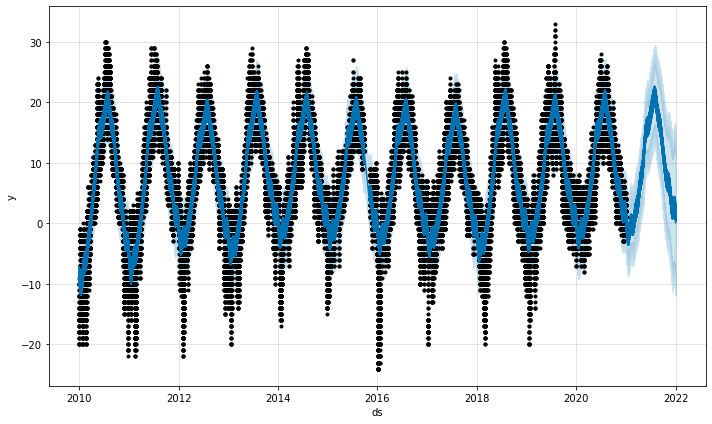

In [14]:
fig1 = m.plot(forecast)

We can observe that we have reasonable predictions, but we are not adapting to the most extreme values registered of temperature. It seems that we are underfitting. Still as a first approach we are able to predict reasonably trends in temperature.

We will also evaluate the different components of our prediction

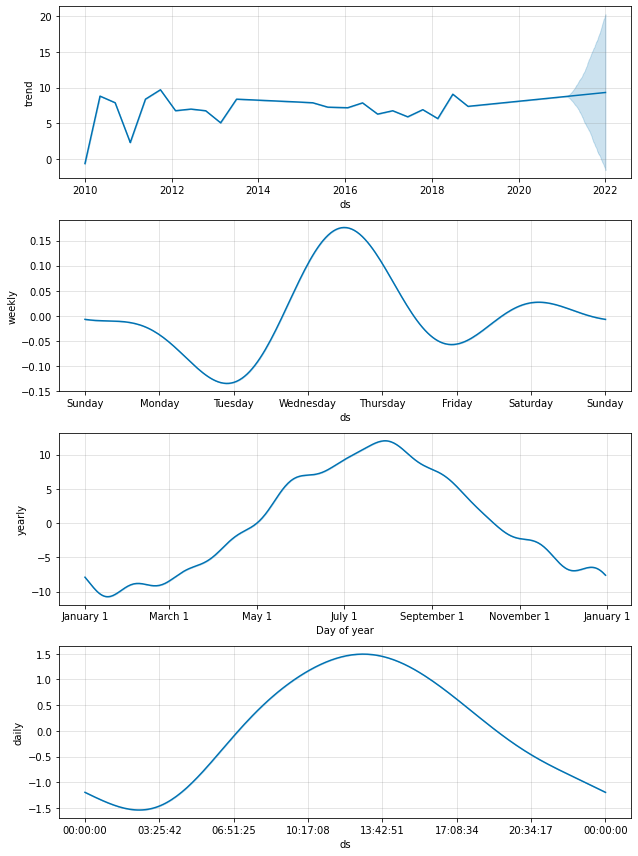

In [15]:
fig2 = m.plot_components(forecast)

We can observe that yearly and daily trends make sense considering that we are evaluating temperature in Helsinki. We can also observe an overall trend in the last 10 years, in average yearly temperatures are increasing.

Weekly variability is not intuitive, but also the scale of the change is quite small.

We will evaluate also the change points considered by Prophet as a sanity check. Including more change points and using a sparser prior are some of the parameters that we can tune in Prophet to have more accurate predictions. In this particular case we can try to predict only one hour of the day, instead of the full day.

Another option would be to remove outliers. Considering that extreme temperatures are present in almost every winter, they are not really an outlier.

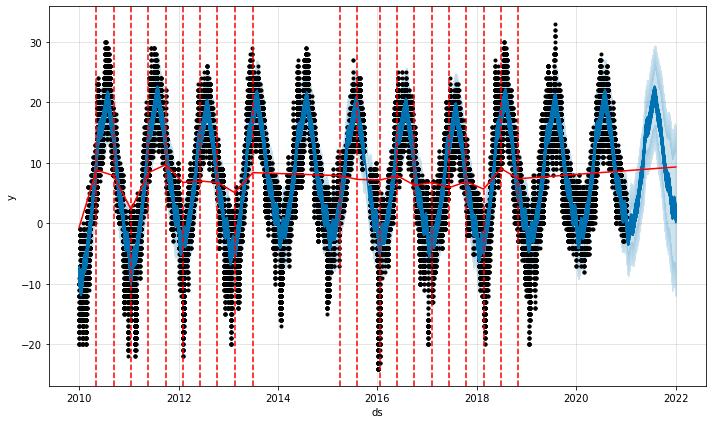

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

# Alternative model comparison and cross validation

We will now fit different models to see how predictions change.

Because including all the hours during the day complicates the visibility of the prediction, we will start by creating a model based on daily values at 15:00. This is really simple to do in Prophet, we can fit the model using a filtered Data Frame and we need to change the frequency of the future Data Frame to adapt to it.

In [17]:
# Fitting a daily model
m2 = Prophet()
fc2 = m2.fit(df[df['ds'].dt.hour == 15]).predict(m2.make_future_dataframe(periods = 365, freq = 'D'))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


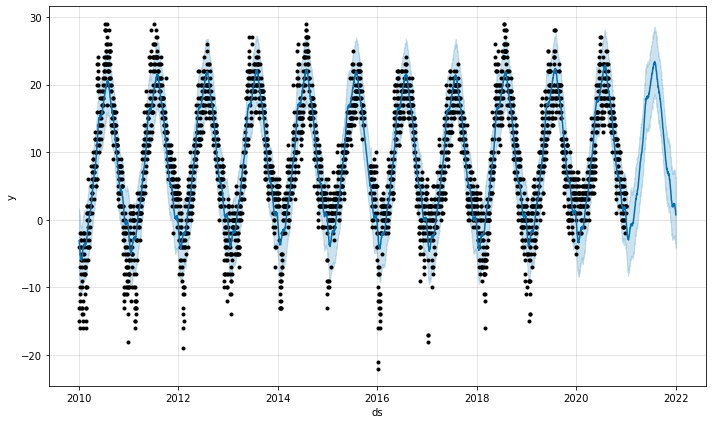

In [18]:
fig1 = m2.plot(fc2)

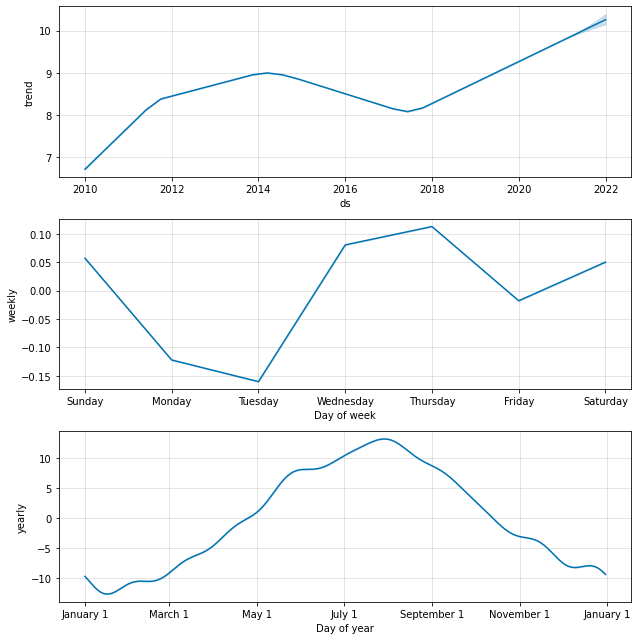

In [19]:
fig2 = m2.plot_components(fc2)

Visually predictions seem more accurate and the trend has a less volatile pattern.

To confirm apparent differences in the prediction we will also use cross validation.

In [20]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [21]:
cutoffs = pd.to_datetime(['2015-07-01','2017-01-01','2018-07-01','2020-01-01'])

In [22]:
df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '365 days', parallel = "processes")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe16b8fe7d0>


In [24]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-01 01:00:00,15.567725,10.890359,20.210205,15,2015-07-01
1,2015-07-01 02:00:00,15.432742,10.656813,19.946748,15,2015-07-01
2,2015-07-01 03:00:00,15.388823,10.863201,19.990084,15,2015-07-01
3,2015-07-01 04:00:00,15.491295,10.911547,20.158992,15,2015-07-01
4,2015-07-01 05:00:00,15.764750,10.735373,20.269702,16,2015-07-01


In [23]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
34021,2020-12-30 20:00:00,-1.186440,-13.388121,10.801590,3,2020-01-01
34022,2020-12-30 21:00:00,-1.459774,-14.327969,9.759361,3,2020-01-01
34023,2020-12-30 22:00:00,-1.697362,-14.302043,9.498576,3,2020-01-01
34024,2020-12-30 23:00:00,-1.921626,-15.067667,9.907889,3,2020-01-01
34025,2020-12-31 00:00:00,-2.148550,-14.349832,9.124721,2,2020-01-01


In [25]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,35 days 11:00:00,29.958011,5.473391,4.653924,0.328475,0.567754
1,35 days 12:00:00,29.942786,5.472000,4.652086,0.326339,0.568195
2,35 days 13:00:00,29.926253,5.470489,4.650215,0.325243,0.568636
3,35 days 14:00:00,29.911614,5.469151,4.648532,0.325243,0.568930
4,35 days 15:00:00,29.898260,5.467930,4.646449,0.324959,0.569224


In [27]:
df_p.tail()

,horizon,mse,rmse,mae,mdape,coverage
7905,364 days 20:00:00,12.042916,3.470290,2.785422,0.374326,0.999412
7906,364 days 21:00:00,12.025448,3.467773,2.783776,0.374326,0.999412
7907,364 days 22:00:00,12.007727,3.465217,2.782330,0.374805,0.999412
7908,364 days 23:00:00,11.994392,3.463292,2.781672,0.374805,0.999412
7909,365 days 00:00:00,11.980420,3.461274,2.780442,0.374805,0.999412


By default 10% of the cv values are included in the rolling window, but we can select all of the values having a unique rolling window

In [28]:
performance_metrics(df_cv, rolling_window=1)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,365 days,16.02919,4.003647,3.126301,0.353481,0.883677


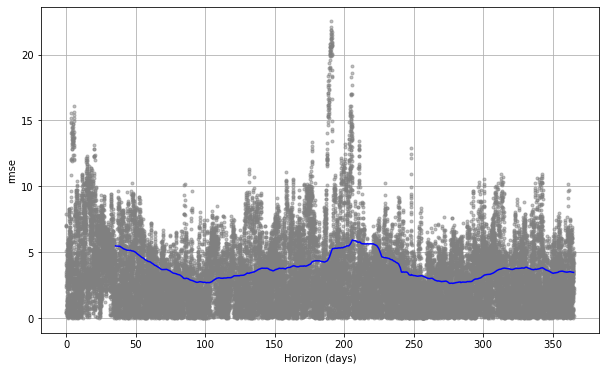

In [29]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

We notice that we have reasonable estimates for one year period. Also the error seems to have a seasonal behaviour. Most likely related to winter and summer seasons when the values are more extreme.

In [30]:
df_cv2 = cross_validation(m2, cutoffs=cutoffs, horizon = '365 days', parallel = "processes")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe1350a0c90>


In [31]:
performance_metrics(df_cv2).tail()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
325,360 days 15:00:00,12.627396,3.553505,2.909807,0.322793,0.843972
326,361 days 15:00:00,12.599219,3.549538,2.912896,0.338774,0.849291
327,362 days 15:00:00,12.596262,3.549121,2.912075,0.317587,0.854610
328,363 days 15:00:00,12.535560,3.540559,2.892264,0.305883,0.851064
329,364 days 15:00:00,12.387079,3.519528,2.875189,0.305883,0.849291


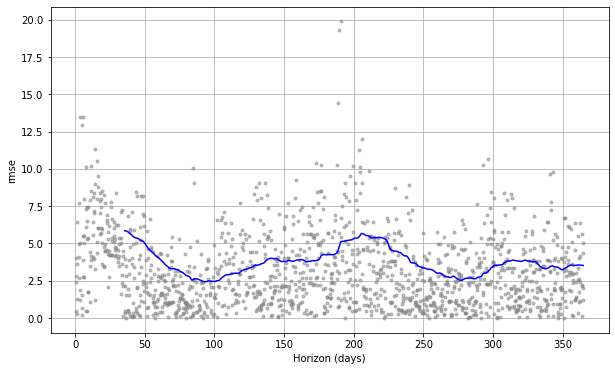

In [32]:
fig3 = plot_cross_validation_metric(df_cv2, metric='rmse')

The error doesn't really decreases if we use only one hour a day to model, instead of every hour during the day. Especially it increases slightly when predicting longer horizons.

It can be benefitial to predict only using one hour in terms of speed. If you need higher granularity of predictions using the whole data set doesn't affect the predictive power so it is recommended.

# Hyperparameter tunning

Our parameter grid will evaluate different change point prior scales. Sparser or tighter prior of the change points will affect directly the trend prediction. We will also consider different seasonality prior scales, for the same control of seasonalities within the trend.

Other important parameters like holidays prior scale and seasonality mode are not considered due to the nature of the problem. There's no holidays effect affecting temperatures and the seasonality effect is not increasing with time.

In [33]:
import itertools
import numpy as np

In [34]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.5, 'seasonal

Running all the cross validation models $4 \cdot 16$ for the hourly Dataframe will take some time

In [35]:
# Differents rmse will be stored
rmses = []

# Use cross validation to evaluate all parameters
for params in all_params:
    ms = Prophet(**params).fit(df)  # Fit model with given params
    df_cvs = cross_validation(ms, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    
    # Includes 100% of the cross validation values in the rolling window
    df_ps = performance_metrics(df_cvs, rolling_window=1)
    rmses.append(df_ps['rmse'].values[0])

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe1367410>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe0e2f950>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe18560d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe0e55710>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe09300d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe0e2f4d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbpro

In [37]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  4.086939
1                     0.001                     0.10  4.095742
2                     0.001                     1.00  4.100228
3                     0.001                    10.00  4.093191
4                     0.010                     0.01  3.995676
5                     0.010                     0.10  3.997276
6                     0.010                     1.00  3.998168
7                     0.010                    10.00  4.001982
8                     0.100                     0.01  4.120993
9                     0.100                     0.10  4.102517
10                    0.100                     1.00  4.098570
11                    0.100                    10.00  4.108047
12                    0.500                     0.01  4.227088
13                    0.500                     0.10  4.196799
14                    0.500                     1.00  4

In [38]:
# Best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


Differences in RMSE are small but the biggest difference is made by change_point_prior_scale. Best results overall are achieved with a change_point_prior_scale of 0.01, default is 0.05. Effect of seasonality_prior_scale seem less relevant, best result is achieved for 0.01. This means to have a smaller effect due to seasonality, considering default value is 10.

We will create a new grid to include the default change_point_prior_scale default value

In [39]:
param_grid2 = {
    'changepoint_prior_scale': [0.01, 0.025, 0.05],
    'seasonality_prior_scale': [0.01, 0.1, 10.0],
}

# Generate all combinations of parameters
all_params2 = [dict(zip(param_grid2.keys(), v)) for v in itertools.product(*param_grid2.values())]
all_params2

[{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}]

In [40]:
# Differents rmse will be stored
rmses2 = []

# Use cross validation to evaluate all parameters
for params in all_params2:
    ms = Prophet(**params).fit(df)  # Fit model with given params
    df_cvs = cross_validation(ms, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    
    # Includes 100% of the cross validation values in the rolling window
    df_ps = performance_metrics(df_cvs, rolling_window=1)
    rmses2.append(df_ps['rmse'].values[0])

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe09447d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfdff2d2d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe18bb0f8d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfdbb81110>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe09447d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdfe0e55050>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbpro

In [41]:
# Find the best parameters
tuning_results2 = pd.DataFrame(all_params2)
tuning_results2['rmse'] = rmses2
print(tuning_results2)

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                    0.010                     0.01  3.995676
1                    0.010                     0.10  3.997276
2                    0.010                    10.00  4.001982
3                    0.025                     0.01  3.958503
4                    0.025                     0.10  3.974054
5                    0.025                    10.00  3.964650
6                    0.050                     0.01  4.012677
7                    0.050                     0.10  4.006483
8                    0.050                    10.00  4.003647


In [42]:
# Best parameters
best_params2 = all_params2[np.argmin(rmses2)]
print(best_params2)

{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.01}


Differences between default parameters (0.05, 10) and best parameters are small, indicating that default parameters were a good solution to the problem. We will now run the model with the best parameters to see potential changes.

In [43]:
# Fitting the model using the temperature dataframe
mb = Prophet(changepoint_prior_scale = 0.025, seasonality_prior_scale = 0.01).fit(df)

In [44]:
# Forecast temperatures
fcb = mb.predict(future)

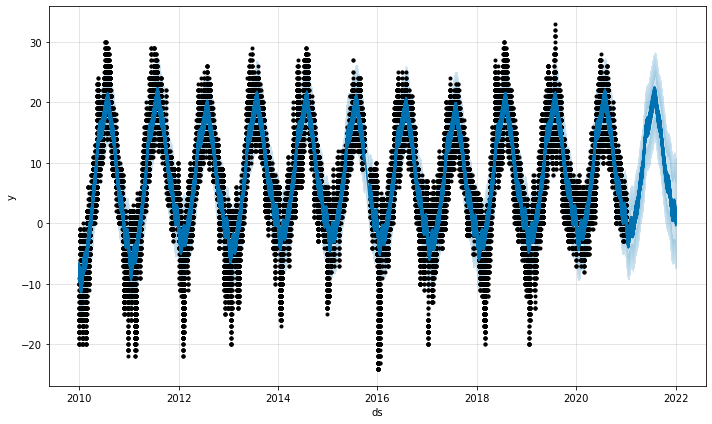

In [45]:
fig1 = mb.plot(fcb)

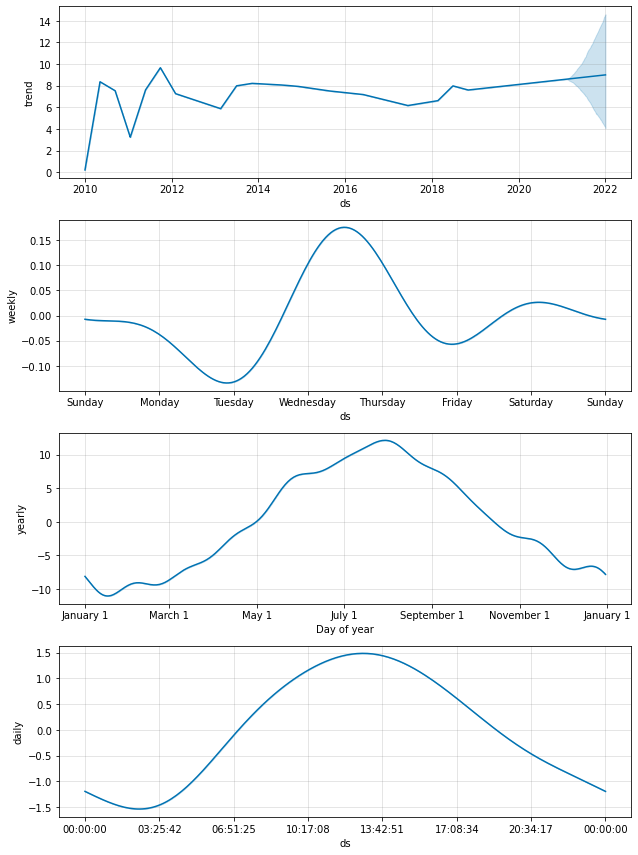

In [46]:
fig2 = mb.plot_components(fcb)

# Conclusions

- We have reasonable predictions for temperature
- Temperature is increasing over the last 4 years. First years were a little more volatile due to less information available.
- The increase in temperature is at least 1 degree from the first half of 2018.